In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/league-of-legends-champion-data/200125_LoL_champion_data.csv')
df = df[['client_positions','adaptivetype','difficulty','apiname']].dropna()

rows = []
for _, row in df.iterrows():
    lanes = eval(row['client_positions'])
    for lane in lanes:
        rows.append({
            'lane': lane,
            'adaptivetype': row['adaptivetype'],
            'difficulty': int(row['difficulty']),
            'apiname': row['apiname']
        })
data = pd.DataFrame(rows)

# Xây dựng các bảng ánh xạ cho mã hóa
lane2idx = {l:i for i,l in enumerate(sorted(data['lane'].unique()))}     
atype2idx = {a:i for i,a in enumerate(sorted(data['adaptivetype'].unique()))}
diff2idx = {d:i for i,d in enumerate(sorted(data['difficulty'].unique()))} 
champ2idx = {ch:i for i,ch in enumerate(sorted(data['apiname'].unique()))}
idx2champ = {i:ch for ch,i in champ2idx.items()}

data['lane_idx'] = data['lane'].map(lane2idx)
data['atype_idx'] = data['adaptivetype'].map(atype2idx)
data['diff_idx'] = data['difficulty'].map(diff2idx)
data['label'] = data['apiname'].map(champ2idx)

X_lane = data['lane_idx'].values
X_atype = data['atype_idx'].values
X_diff = data['diff_idx'].values
y = data['label'].values


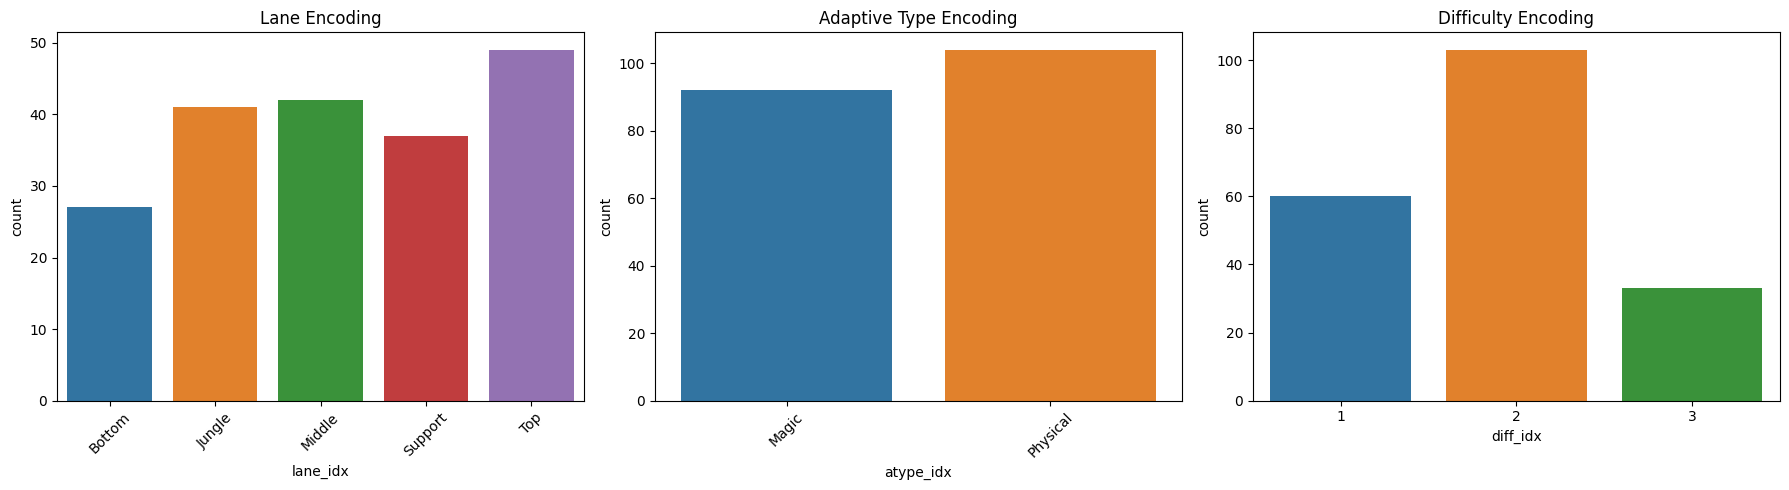

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='lane_idx', data=data, ax=axes[0])
axes[0].set_title("Lane Encoding")
axes[0].set_xticks(list(lane2idx.values()))
axes[0].set_xticklabels(list(lane2idx.keys()), rotation=45)

sns.countplot(x='atype_idx', data=data, ax=axes[1])
axes[1].set_title("Adaptive Type Encoding")
axes[1].set_xticks(list(atype2idx.values()))
axes[1].set_xticklabels(list(atype2idx.keys()), rotation=45)

sns.countplot(x='diff_idx', data=data, ax=axes[2])
axes[2].set_title("Difficulty Encoding")
axes[2].set_xticks(list(diff2idx.values()))
axes[2].set_xticklabels(list(diff2idx.keys()))

plt.tight_layout()
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout

num_lanes = len(lane2idx)     
num_atypes = len(atype2idx)   
num_diffs = len(diff2idx)     
num_champions = len(champ2idx)  

# Đầu vào cho từng đặc tính
input_lane = Input(shape=(1,), name='input_lane')
input_atype = Input(shape=(1,), name='input_atype')
input_diff = Input(shape=(1,), name='input_diff')

# Lớp embedding cho mỗi đặc tính
embed_lane = Embedding(input_dim=num_lanes, output_dim=8, name='embed_lane')(input_lane)
embed_atype = Embedding(input_dim=num_atypes, output_dim=4, name='embed_atype')(input_atype)
embed_diff = Embedding(input_dim=num_diffs, output_dim=3, name='embed_diff')(input_diff)

# Làm phẳng và ghép nối các embedding
flat_lane = Flatten()(embed_lane)
flat_atype = Flatten()(embed_atype)
flat_diff = Flatten()(embed_diff)
concat = concatenate([flat_lane, flat_atype, flat_diff], name='concat_features')

# Các tầng fully-connected (Dense) ẩn
x = Dense(64, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Lớp đầu ra softmax cho các tướng
output = Dense(num_champions, activation='softmax', name='output')(x)

model = Model(inputs=[input_lane, input_atype, input_diff], outputs=output)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
model.summary()


2025-07-21 03:17:03.613007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753067823.796488      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753067823.850129      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1753067835.911342      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753067835.912002      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_lane          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_atype         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_diff          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_lane          │ (None, 1, 8)      │         40 │ input_lane[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_atype         │ (None, 1, 4)      │          8 │ input_atype[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_diff          │ (None, 1, 3)      │          9 │ input_diff[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embed_lane[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embed_atype[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3)         │          0 │ embed_diff[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 15)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,024 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 171)       │      5,643 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,804 (34.39 KB)

 Trainable params: 8,804 (34.39 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from sklearn.model_selection import train_test_split

# Chia riêng từng thành phần của X
X_lane_train, X_lane_test, X_atype_train, X_atype_test, X_diff_train, X_diff_test, y_train, y_test = train_test_split(
    X_lane, X_atype, X_diff, y, test_size=0.1, random_state=42)

# Train
history = model.fit(
    x=[X_lane_train, X_atype_train, X_diff_train],
    y=y_train,
    validation_data=([X_lane_test, X_atype_test, X_diff_test], y_test),
    epochs=90,
    batch_size=16
)


Epoch 1/90


I0000 00:00:1753067849.965487     105 service.cc:148] XLA service 0x7c7c10004ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753067849.966035     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753067849.966053     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753067850.223318     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.0000e+00 - loss: 5.1421 - sparse_top_k_categorical_accuracy: 0.0000e+00

I0000 00:00:1753067851.710366     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.0000e+00 - loss: 5.1431 - sparse_top_k_categorical_accuracy: 0.0243 - val_accuracy: 0.0000e+00 - val_loss: 5.1471 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0085 - loss: 5.1396 - sparse_top_k_categorical_accuracy: 0.0822 - val_accuracy: 0.0000e+00 - val_loss: 5.1549 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0171 - loss: 5.1370 - sparse_top_k_categorical_accuracy: 0.0721 - val_accuracy: 0.0000e+00 - val_loss: 5.1629 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0243 - loss: 5.1341 - sparse_top_k_categorical_accuracy: 0.0961 - val_accuracy: 0.0000e+00 - val_loss: 5.1731 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0400 - loss: 5.1311 - sparse_top_k_ca

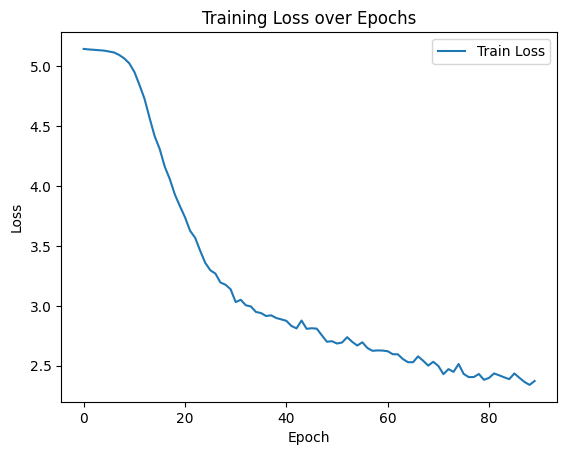

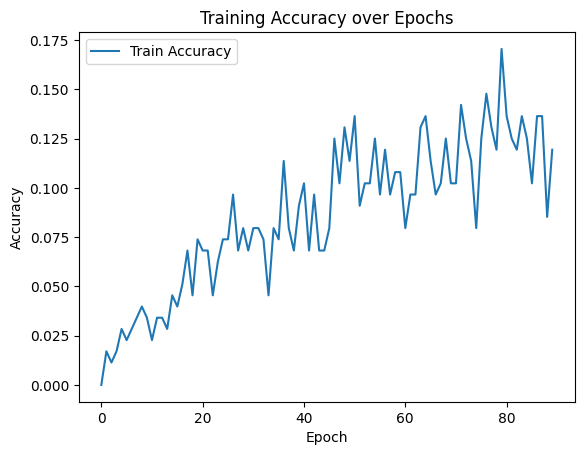

In [4]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
def recommend_champions(model, lane, adaptivetype, experience, threshold=0.05):
    # Chuyển đổi đầu vào sang chỉ số
    lane_idx = np.array([[lane2idx.get(lane, 0)]])
    atype_idx = np.array([[atype2idx.get(adaptivetype, 0)]])
    diff_idx = np.array([[diff2idx.get(experience, 1)]])  # mặc định 1 nếu không có

    # Dự đoán xác suất các tướng
    probs = model.predict([lane_idx, atype_idx, diff_idx], verbose=0)[0]

    # Chỉ lấy các tướng có xác suất vượt ngưỡng
    filtered_idx = np.where(probs >= threshold)[0]
    sorted_idx = filtered_idx[np.argsort(probs[filtered_idx])[::-1]]

    # Trả về danh sách các tướng phù hợp
    champions = [(idx2champ[i], probs[i]) for i in sorted_idx]
    return champions

In [30]:
import numpy as np

recs = recommend_champions(
    model,
    lane='Support',
    adaptivetype='Physical',
    experience=2,
    threshold=0.11
)

print("Recommended champions:")
for champ, score in recs:
    print(f"- {champ}: {score:.2f}")


Recommended champions:
- Pyke: 0.50
- Senna: 0.39


In [54]:
import gradio as gr
import numpy as np

def recommend_champions(model, lane, adaptivetype, experience):
    threshold = 0.11
    lane_idx = np.array([[lane2idx.get(lane, 0)]])
    atype_idx = np.array([[atype2idx.get(adaptivetype, 0)]])
    diff_idx = np.array([[diff2idx.get(experience, 1)]])
    probs = model.predict([lane_idx, atype_idx, diff_idx], verbose=0)[0]
    filtered_idx = np.where(probs >= threshold)[0]
    sorted_idx = filtered_idx[np.argsort(probs[filtered_idx])[::-1]]
    champions = [idx2champ[i] for i in sorted_idx]
    return champions

def get_recommendations(lane, adaptivetype, experience):
    try:
        experience = int(experience)
    except:
        return "Kinh nghiệm phải là số nguyên (0, 1 hoặc 2)."
    results = recommend_champions(model, lane, adaptivetype, experience)
    if not results:
        return "Không có tướng phù hợp."
    return "\n".join([f"- {champ}" for champ in results])

lane_options = list(lane2idx.keys())
atype_options = list(atype2idx.keys())
exp_options = list(diff2idx.keys())

with gr.Blocks(css=".gr-box {max-width: 800px; margin: auto;}") as demo:
    gr.Markdown("""
    # Gợi ý Tướng - Liên Minh Huyền Thoại
    Nhập vào thông tin của bạn để nhận danh sách tướng phù hợp.
    """)
    
    with gr.Column():
        lane_in = gr.Dropdown(choices=lane_options, label="Lane")
        atype_in = gr.Dropdown(choices=atype_options, label="Thể loại sát thương")
        exp_in = gr.Dropdown(choices=exp_options, label="Kinh nghiệm chơi game thể loại Moba(1: Mới chơi, 2: Có một chút kinh nghiệm, 3: Có kinh nghiệm dày dặn)")
        btn = gr.Button("Gợi ý tướng")
        output = gr.Textbox(label="Danh sách tướng đề xuất", lines=10, interactive=False)

    btn.click(fn=get_recommendations, inputs=[lane_in, atype_in, exp_in], outputs=output)

demo.launch()


* Running on local URL:  http://127.0.0.1:7876
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://d275c6043b14edb11e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
